## IMPORTS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

from metrics.dataquality import calculate_data_quality_metrics, calculate_average_metrics

from metrics.overallscore import calculate_overall_score
from metrics.overallscore import calculate_overall_score_mom

from metrics.feature_calculations import calculate_unique_meter_count
from metrics.feature_calculations import calculate_metrics_by_month

from metrics.datacollectorscore import calculate_quality_score_by_collector

## READING DATA

In [2]:
data = pd.read_csv("data/yedc/yedc_caims_data2.csv")

In [4]:
column_mapping = {
    'slrn': 'SLRN',
    'ac_no': 'Account Number',
    'meter_number': 'Meter Number',
    'meter_status': 'Meter Status',
    'meter_slrn': 'Meter SLRN',
    'phone_number': 'Phone Number',
    'email': 'Email',
    'date': 'Date',
    'first_captured_username': 'First Captured Username',
    'updated_username': 'Updated Username'
}
data_x = data.copy()
data_x.rename(columns=column_mapping, inplace=True)

In [5]:
filtered_data_yedc = data_x

In [6]:
df = filtered_data_yedc.copy()

## METRICS

In [7]:
metrics_list = []

# Calculate metrics for each key field
key_fields = ['SLRN', 'Account Number', 'Meter Number', 'Phone Number', 'Email']

for field_name in key_fields:
    if field_name in df.columns:
        if field_name in ['SLRN', 'Account Number', 'Meter Number']:
            metrics = calculate_data_quality_metrics(df, field_name, 'YEDCBD', 13)
        elif field_name == 'Phone Number':
            metrics = calculate_data_quality_metrics(df, field_name, 'YEDCBD', 13)
        elif field_name == 'Email':
            metrics = calculate_data_quality_metrics(df, field_name, 'YEDCBD', 13)
        
        metrics_list.append(metrics)

# Calculate average completeness, validity, and integrity
average_completeness = calculate_average_metrics(metrics_list, 'Completeness')
average_validity = calculate_average_metrics(metrics_list, 'Validity')
average_integrity = calculate_average_metrics(metrics_list, 'Integrity')

# Calculate overall score using the overall_score function
overall_score = calculate_overall_score(average_completeness, average_validity, average_integrity)

total_caims_data = df['SLRN'].count()
print(f'\nSample Data: {total_caims_data:,}')

# Display the results
print("\nQuality Metrics for Each Field:")
for field_name in key_fields:
    if field_name in df.columns:
        print(f"\nMetrics for {field_name}:")
        print(f"Completeness: {metrics_list[key_fields.index(field_name)]['Completeness']:.2f}%")
        print(f"Validity: {metrics_list[key_fields.index(field_name)]['Validity']:.2f}%")
        print(f"Integrity: {metrics_list[key_fields.index(field_name)]['Integrity']:.2f}%")
        
        # Calculate and print the overall score for each field
        field_overall_score = calculate_overall_score(
            metrics_list[key_fields.index(field_name)]['Completeness'],
            metrics_list[key_fields.index(field_name)]['Validity'],
            metrics_list[key_fields.index(field_name)]['Integrity']
        )
        print(f"Overall Score: {field_overall_score:.2f}")

print("\nQuality Metrics - Average and Overall Score:")
print(f"Average Completeness: {average_completeness:.2f}%")
print(f"Average Validity: {average_validity:.2f}%")
print(f"Average Integrity: {average_integrity:.2f}%")
print(f"Overall Score: {overall_score:.2f}")



Sample Data: 6,822

Quality Metrics for Each Field:

Metrics for SLRN:
Completeness: 100.00%
Validity: 99.99%
Integrity: 98.48%
Overall Score: 99.60

Metrics for Account Number:
Completeness: 98.27%
Validity: 98.21%
Integrity: 81.57%
Overall Score: 94.80

Metrics for Meter Number:
Completeness: 81.79%
Validity: 81.78%
Integrity: 81.78%
Overall Score: 82.00

Metrics for Phone Number:
Completeness: 90.00%
Validity: 89.99%
Integrity: 73.54%
Overall Score: 86.80

Metrics for Email:
Completeness: 38.48%
Validity: 38.29%
Integrity: 29.96%
Overall Score: 36.40

Quality Metrics - Average and Overall Score:
Average Completeness: 81.71%
Average Validity: 81.65%
Average Integrity: 73.07%
Overall Score: 80.40


In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year Month'] = df['Date'].dt.to_period('M')
df['date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
df["date"] = df.date.astype(str)
df["year_month"] = df.date.str[0:7]
df["year_month"] = df.year_month.str.replace('-', '')
df["year_month"] = df.year_month.apply(lambda x: int(x) if str(x).isdigit() else 0)

In [9]:
# Compute unique meter count
unique_meter_count_df = calculate_unique_meter_count(df, 'Year Month', 'Meter Number')


# Calculate overall data quality score on a monthly basis and link it back to the DataFrame
mom_overall_score = calculate_overall_score_mom(df)
mom_overall_score_fil = mom_overall_score[mom_overall_score['year_month'] >= 202301]
mom_overall_score_fil = mom_overall_score_fil[['Year Month', 'Overall Score', 'year_month']]
mom_overall_score_fil = mom_overall_score_fil.sort_values(by='year_month', ascending=True)
mom_overall_score_fil = mom_overall_score_fil.drop_duplicates(subset=['Year Month'])

mom_overall_score_fil = pd.merge(mom_overall_score_fil, unique_meter_count_df, on='Year Month', how='left')

## MOM CHART

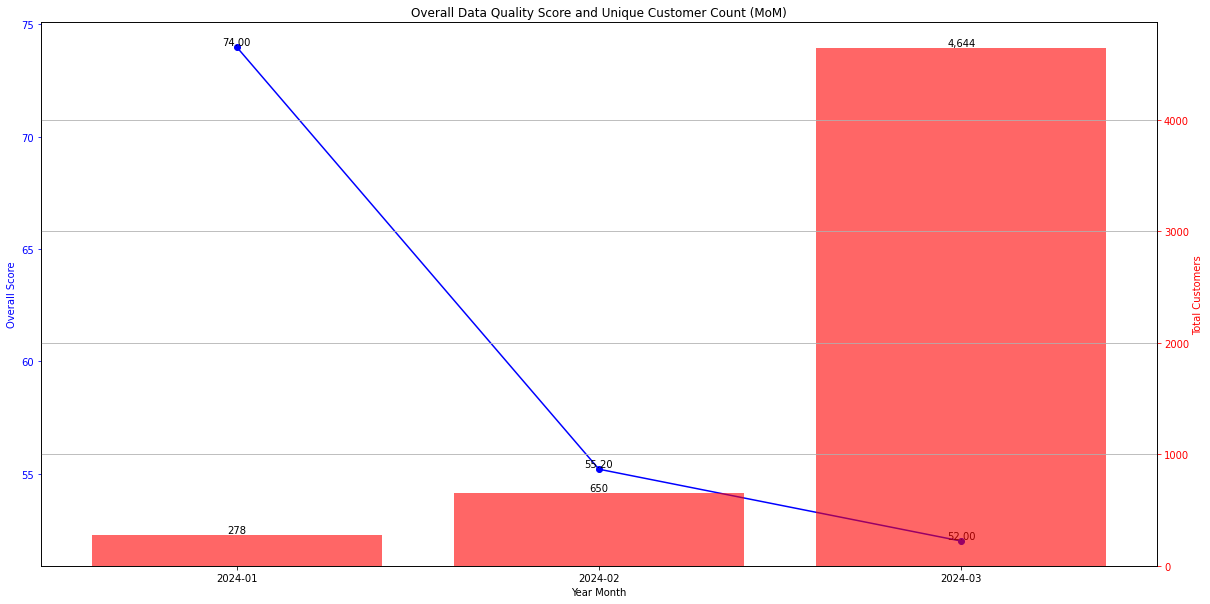

In [10]:
# Plot overall data quality score on a MoM basis
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the overall score on the primary y-axis
ax1.plot(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Overall Score'].round(2), marker='o', linestyle='-', color='b', label='Overall Score')
ax1.set_xlabel('Year Month')
ax1.set_ylabel('Overall Score', color='b')
ax1.tick_params('y', colors='b')

# Text annotations
for i, txt in enumerate(mom_overall_score_fil['Overall Score'].round(2)):
    ax1.text(mom_overall_score_fil['Year Month'].astype(str).iloc[i], txt, f'{txt:.2f}', ha='center', va='bottom')

# Secondary y-axis for the count of unique meter numbers
ax2 = ax1.twinx()
bars = ax2.bar(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Unique Meter Count'], alpha=0.6, color='red', label='Unique Meter Count')
ax2.set_ylabel('Total Customers', color='r')
ax2.tick_params('y', colors='r')

# Add labels on the bar chart with MoM figures
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', va='bottom', ha='center')

# Show the plot
plt.title('Overall Data Quality Score and Unique Customer Count (MoM)')
plt.grid(True)
plt.show()


In [10]:
# mom_overall_score_fil[['Year Month', 'Overall Score']].to_csv('data/exports/mom_overall_score_dec_2023.csv', index=False)

In [11]:
mom_overall_score_fil

,Year Month,Overall Score,year_month,Unique Meter Count
0,2024-01,74.0,202401,278
1,2024-02,55.2,202402,650
2,2024-03,52.0,202403,4644


### CALCULATE METRICS BY MONTH

In [11]:
key_fields = ['SLRN', 'Account Number', 'Meter Number', 'Phone Number', 'Email']

mom_data_quality_metrics = calculate_metrics_by_month(
    df, 
    key_fields, 
    bd_slrn='YEDCBD', 
    bdslrn_len=13, 
)

c:\Users\Moshood\OneDrive\dev\analysis\data_quality_management\metrics\dataquality.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Processed Meter Number'] = df[field_name].apply(preprocess_meter_number)
c:\Users\Moshood\OneDrive\dev\analysis\data_quality_management\metrics\dataquality.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Meter Number Validity'] = df['Processed Meter Number'].apply(is_valid_meter_number)
c:\Users\Moshood\OneDrive\dev\analysis\data_quality_management\metrics\data

In [12]:
mom_data_quality_metrics

,Year Month,Key fields,Completeness,Validity,Integrity,Average Completeness,Average Validity,Average Integrity,Overall Score,Unique Meter Count
0,2024-01,SLRN,100.000000,99.685535,98.742138,96.289308,96.163522,88.867925,94.4,278
1,2024-01,Account Number,97.484277,97.169811,86.163522,96.289308,96.163522,88.867925,94.4,278
2,2024-01,Meter Number,87.735849,87.735849,87.735849,96.289308,96.163522,88.867925,94.4,278
3,2024-01,Phone Number,98.742138,98.742138,86.477987,96.289308,96.163522,88.867925,94.4,278
4,2024-01,Email,97.484277,97.484277,85.220126,96.289308,96.163522,88.867925,94.4,278
5,2024-02,SLRN,100.000000,100.000000,99.089069,86.376518,86.336032,67.591093,82.4,650
6,2024-02,Account Number,99.089069,98.886640,65.890688,86.376518,86.336032,67.591093,82.4,650
7,2024-02,Meter Number,65.890688,65.890688,65.890688,86.376518,86.336032,67.591093,82.4,650
8,2024-02,Phone Number,94.433198,94.433198,61.437247,86.376518,86.336032,67.591093,82.4,650
9,2024-02,Email,72.469636,72.469636,45.647773,86.376518,86.336032,67.591093,82.4,650


In [14]:
mom_overall_score_fil_two = mom_data_quality_metrics[['Year Month', 'Overall Score', 'Unique Meter Count']]

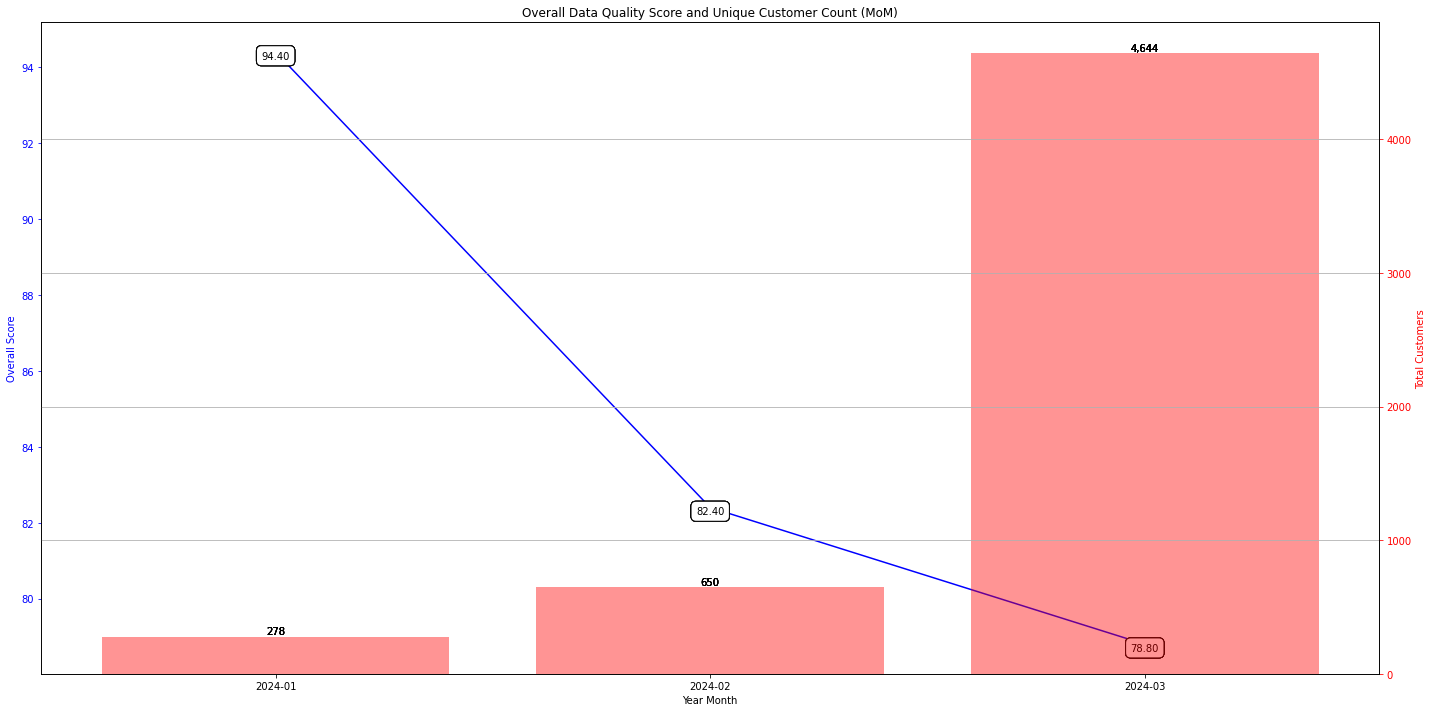

In [15]:
import matplotlib.pyplot as plt

# Plot overall data quality score on a MoM basis
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the overall score on the primary y-axis
ax1.plot(mom_overall_score_fil_two['Year Month'].astype(str), mom_overall_score_fil_two['Overall Score'].round(2), marker='o', linestyle='-', color='b', label='Overall Score')
ax1.set_xlabel('Year Month')
ax1.set_ylabel('Overall Score', color='b')
ax1.tick_params('y', colors='b')

# Text annotations with adjusted positions
for i, (x, y) in enumerate(zip(mom_overall_score_fil_two['Year Month'].astype(str), mom_overall_score_fil_two['Overall Score'].round(2))):
    ax1.text(x, y - 0.23, f'{y:.2f}', ha='center', va='bottom', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'), zorder=10)

# Secondary y-axis for the count of unique meter numbers
ax2 = ax1.twinx()
bars = ax2.bar(mom_overall_score_fil_two['Year Month'].astype(str), mom_overall_score_fil_two['Unique Meter Count'], alpha=0.1, color='red', label='Unique Meter Count')
ax2.set_ylabel('Total Customers', color='r')
ax2.tick_params('y', colors='r')

# Add labels on the bar chart with MoM figures
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', va='bottom', ha='center')

# Show the plot
plt.title('Overall Data Quality Score and Unique Customer Count (MoM)')
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()


In [16]:
# mom_data_quality_metrics.to_csv('data/exports/mom_metrics.csv', index=False)

## DATA QUALITY DATA

In [16]:
from metrics.dataquality_data import calculate_validity
from metrics.dataquality_data import calculate_integrity

# Define the fields of interest
fields_of_interest = ['SLRN', 'Account Number', 'Meter Number', 'Phone Number', 'Email']

# Initialize a dictionary to store the results
results = {}

# Iterate through each field of interest
for field in fields_of_interest:
    # Calculate validity and integrity for the current field
    validity = calculate_validity(df, field, slrn_prefix='YEDCBD', slrn_length=13)
    integrity = calculate_integrity(df, field, corresponding_meter_field='Meter Number')
    
    # Add validity and integrity to the results dictionary
    results[f"{field}"] = df[field]
    results[f"{field} Validity"] = validity
    results[f"{field} Integrity"] = integrity

results['Date'] = df['Date']
results['Meter Status'] = df['Meter Status']

result_df = pd.DataFrame(results)

ModuleNotFoundError: No module named 'dataquality'

In [ ]:
data_quality_data = result_df[(result_df['Date'].dt.year == 2024) & (result_df['Date'].dt.month == 3)]


data_quality_data.to_csv('data/exports/march_2024_data_quality_data.csv', index=False)